In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from FlagRep import FlagRep


In [2]:
def chordal_distance(X, Y, Bs_x, Bs_y):

    k = len(Bs_x)

    dist = 0

    for i in range(k):
        id_x = Bs_x[i]
        id_y = Bs_y[i]
        Xi = X[:,id_x]
        Yi = Y[:,id_y]
        mm = np.min([len(Bs_x[i]), len(Bs_y[i])])
        sin_sq = mm - np.trace(Xi.T @ Yi @ Yi.T @ Xi)
        if np.isclose(sin_sq,0):
            sin_sq = 0
        elif sin_sq < 0:
            print('sine squared less than 0')
            print(sin_sq)
            sin_sq = 0
        dist += sin_sq

    return np.sqrt(dist)

def compute_noise_fraction(noise_exp):
    return .001*noise_exp#10**(-noise_exp)

def compute_outlier_prop(noise_exp):
    return .05*noise_exp

def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

def generate_data_noise(noise_fraction, noise_dist, n, col_ids, ms):

    #flag type with a 0 in front
    fl_ids = np.hstack([np.array([0]),np.cumsum(ms)])
    n_k = fl_ids[-1]

    # true flag
    X_true = np.linalg.qr(np.random.normal(size = (n,n_k)))[0][:,:n_k]

    p = np.sum(col_ids)
    
    D_true = np.hstack([X_true[:,fl_ids[i]:fl_ids[i+1]] @ np.random.normal(size = (ms[i],col_ids[i])) for i in range(len(col_ids))])
 

    if noise_dist == 'Normal':
        noise = np.random.normal(scale = noise_fraction, size = (n,p))
    elif noise_dist == 'Exponential':
        noise = np.random.exponential(scale = noise_fraction, size = (n,p))
    elif noise_dist == 'Uniform':
        noise = noise_fraction*np.random.uniform(size = (n,p))
    
    D = D_true + noise

    return D, D_true, X_true

def generate_data_outliers(prop_outliers, n, col_ids, ms, verbose = 0):

    #flag type with a 0 in front
    fl_ids = np.hstack([np.array([0]),np.cumsum(ms)])
    n_k = fl_ids[-1]

    # true flag
    X_true = np.linalg.qr(np.random.normal(size = (n,n_k)))[0][:,:n_k]

    p = np.sum(col_ids)
    n_outliers = int(np.floor(prop_outliers*p))
    outlier_subspaces = np.random.randint(len(ms), size = n_outliers)


    D = []
    inlier_ids = []
    outlier_ids = []
    jj=0
    for i in range(len(ms)):
        pi = col_ids[i]
        # get flag and dimension
        Xi = X_true[:,fl_ids[i]:fl_ids[i+1]]
        mi = ms[i]

        n_outliers_i = len(np.where(outlier_subspaces == i)[0])
        n_inliers_i = pi - n_outliers_i

        Bi = []
        for _ in range(n_inliers_i):
            Bi.append(Xi @ np.random.normal(size = (mi,1)))
            inlier_ids.append(jj)
            jj+=1
        for _ in range(n_outliers_i):
            Bi.append(np.random.normal(size = (n,1)))
            outlier_ids.append(jj)
            jj+=1
        
        Bi = np.hstack(Bi)
    
        D.append(Bi)
    
    D = np.hstack(D)

    return D, X_true, np.array(inlier_ids), np.array(outlier_ids)





    #     if noise_type == 'X':
    #         rand_mat = np.random.randn(rows, rank)
    #         outlier_X =  np.linalg.qr(outlierProjMat @ rand_mat)[0][:,:rank]
    #         outlierProjMat = np.eye(rows)- outlier_X @ outlier_X.T
    #         for _ in range(n_outliers):
    #             random_matrix.append(outlier_X @ np.random.normal(size = (rank,1)))
    #             outlier_ids.append(jj)
    #             jj+=1

In [3]:

n_trials = 100
n = 10
col_ids = [20,20]
p = np.sum(col_ids)
Aset = [np.arange(col_ids[0]),np.arange(p)]
fl_type = [2,4]
hidden_ms = [2,2]
noise_exps = range(0,1000,100)
distributions = ['Normal', 'Exponential', 'Uniform']


Bs = make_Bs(fl_type)

/var/folders/5m/bv9phk393431tllslwr8yzyw0000gp/T/ipykernel_70480/2940161219.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,row])


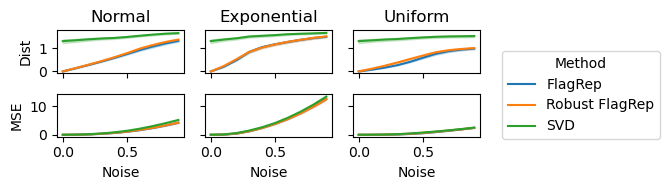

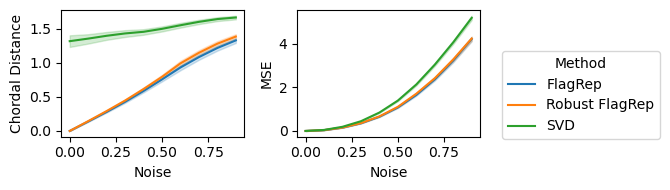

In [4]:

results = pd.DataFrame(columns = ['Method','Chordal Distance', 'Noise', 'Noise Dist',  'MSE'])


for noise_dist in distributions:
    for seed_num in range(n_trials):
        for noise_exp in noise_exps:
            np.random.seed(seed_num)
            
            noise_fraction = compute_noise_fraction(noise_exp) 
            
            D, D_true, hidden_X = generate_data_noise(noise_fraction, noise_dist, n, col_ids, hidden_ms)#, noise_type = noise_type)

            # FlagRep
            my_flag_rep = FlagRep(Aset = Aset, flag_type=fl_type, solver = 'svd')
            X_flagrep, R_flagrep = my_flag_rep.fit_transform(D)
            rec_flagrep = my_flag_rep.inverse_transform(X_flagrep, R_flagrep)

            cdist_flagrep = chordal_distance(hidden_X, X_flagrep, Bs, Bs)
            mse_flagrep = np.sum(np.linalg.norm(rec_flagrep- D_true, axis = 1)**2)/p 

            row = pd.DataFrame(columns = results.columns,
                                data = [['FlagRep',cdist_flagrep, noise_fraction, noise_dist,  mse_flagrep]])
            results = pd.concat([results,row])

            # Robust FlagRep
            my_rflag_rep = FlagRep(Aset = Aset, flag_type=fl_type, solver = 'irls svd')
            X_rflagrep, R_rflagrep = my_rflag_rep.fit_transform(D)
            rec_rflagrep = my_rflag_rep.inverse_transform(X_rflagrep, R_rflagrep)

            cdist_rflagrep = chordal_distance(hidden_X, X_rflagrep, Bs, Bs)
            mse_rflagrep = np.sum(np.linalg.norm(rec_rflagrep- D_true, axis = 1)**2)/p 

            row = pd.DataFrame(columns = results.columns,
                                data = [['Robust FlagRep',cdist_rflagrep, noise_fraction, noise_dist, mse_rflagrep]])
            results = pd.concat([results,row])

            # SVD
            X_svd = np.linalg.svd(D)[0][:,:fl_type[-1]]

            cdist_svd = chordal_distance(hidden_X, X_svd, Bs, Bs)
            mse_svd = np.sum(np.linalg.norm(X_svd @ X_svd.T @ D - D_true, axis = 1)**2)/p 

            row = pd.DataFrame(columns = results.columns,
                                data = [['SVD',cdist_svd, noise_fraction, noise_dist, mse_svd]])
            results = pd.concat([results,row])

fig, ax = plt.subplots(2,3, figsize = (5,2), sharey = 'row', sharex = True)
for i, noise_dist in enumerate(distributions):
    
    idx = results['Noise Dist'] == noise_dist
    sns.lineplot(results[idx], x = 'Noise', y = 'Chordal Distance', hue = 'Method', ax = ax[0,i])
    ax[0,0].set_ylabel('Dist')
    ax[0,i].set_title(noise_dist)
    sns.lineplot(results[idx], x = 'Noise', y = 'MSE', hue = 'Method', ax = ax[1,i])
    ax[1,0].set_ylabel('MSE')

for a in ax.flat:
    a.legend_.remove()
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Method")

plt.tight_layout()
plt.savefig(f'../results/noise.pdf', bbox_inches = 'tight')


fig, ax = plt.subplots(1,2, figsize = (5,2))
idx = results['Noise Dist'] == 'Normal'
sns.lineplot(results[idx], x = 'Noise', y = 'Chordal Distance', hue = 'Method', ax = ax[0])
sns.lineplot(results[idx], x = 'Noise', y = 'MSE', hue = 'Method', ax = ax[1])

for a in ax.flat:
    a.legend_.remove()
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Method")

plt.tight_layout()
plt.savefig(f'../results/normal_noise.pdf', bbox_inches = 'tight')


/var/folders/5m/bv9phk393431tllslwr8yzyw0000gp/T/ipykernel_70480/445665744.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,row])


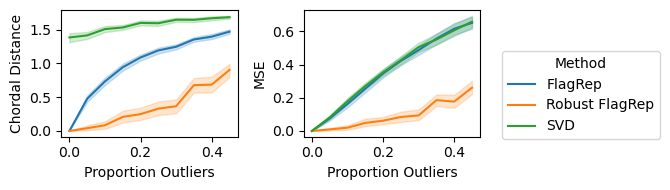

In [5]:
n = 10
col_ids = [20,20]

p = np.sum(col_ids)
Aset = [np.arange(col_ids[0]),np.arange(p)]

outlier_exps = range(0,10)

Bs = make_Bs(fl_type)


results = pd.DataFrame(columns = ['Method','Chordal Distance', 'Proportion Outliers', 'MSE'])
for seed_num in range(n_trials):
    for outlier_exp in outlier_exps:
        np.random.seed(seed_num)
        prop_outliers = compute_outlier_prop(outlier_exp)
        
        D, hidden_Xs, inlier_ids, outlier_ids = generate_data_outliers(prop_outliers, n, col_ids, hidden_ms)
        D_inliers = D[:,inlier_ids]
        n_inliers = len(inlier_ids)
        


        my_flag_rep = FlagRep(Aset = Aset, flag_type=fl_type)
        X_flagrep, R_flagrep = my_flag_rep.fit_transform(D)
        D_flagrep = X_flagrep @ X_flagrep.T @ D
        D_flagrep_inliers = D_flagrep[:,inlier_ids]
        cdist_flagrep = chordal_distance(hidden_Xs,X_flagrep,Bs,Bs)
        mse_flagrep = np.sum(np.linalg.norm(D_flagrep_inliers - D_inliers, axis = 1)**2)/n_inliers
        row = pd.DataFrame(columns = results.columns,
                            data = [['FlagRep',cdist_flagrep, prop_outliers, mse_flagrep]])
        results = pd.concat([results,row])


        my_flag_rep = FlagRep(Aset = Aset, flag_type=fl_type, solver = 'irls svd')
        X_rflagrep, R_rflagrep = my_flag_rep.fit_transform(D)
        D_rflagrep = X_rflagrep @ X_rflagrep.T @ D
        D_rflagrep_inliers = D_rflagrep[:,inlier_ids]
        cdist_rflagrep = chordal_distance(hidden_Xs, X_rflagrep,Bs,Bs)
        
        mse_rflagrep = np.sum(np.linalg.norm( D_rflagrep_inliers - D_inliers, axis = 1)**2)/n_inliers
        row = pd.DataFrame(columns = results.columns,
                            data = [['Robust FlagRep',cdist_rflagrep, prop_outliers, mse_rflagrep]])
        results = pd.concat([results,row])

        X_svd = np.linalg.svd(D)[0][:,:fl_type[-1]]
        mse_svd = np.sum(np.linalg.norm(X_svd @ X_svd.T @ D_inliers - D_inliers, axis = 1)**2)/n_inliers
        cdist_svd = chordal_distance(hidden_Xs, X_svd,Bs,Bs)
        row = pd.DataFrame(columns = results.columns,
                            data = [['SVD',cdist_svd, prop_outliers, mse_svd]])
        results = pd.concat([results,row])

fig, ax = plt.subplots(1,2,  figsize = (5,2))

sns.lineplot(results, x = 'Proportion Outliers', y = 'Chordal Distance', hue = 'Method', ax = ax[0])
sns.lineplot(results, x = 'Proportion Outliers', y = 'MSE', hue = 'Method', ax = ax[1])

for a in ax.flat:
    a.legend_.remove()
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Method")

plt.tight_layout()
plt.savefig(f'../results/outliers.pdf', bbox_inches = 'tight')


